In [48]:
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import mne


In [34]:
eeg_files = sorted(glob.glob('./data/0114ssEEG/*.csv'))

In [35]:
eeg_files

['./data/0114ssEEG/SDS00001.csv',
 './data/0114ssEEG/SDS00002.csv',
 './data/0114ssEEG/SDS00003.csv',
 './data/0114ssEEG/SDS00004.csv',
 './data/0114ssEEG/SDS00005.csv',
 './data/0114ssEEG/SDS00006.csv',
 './data/0114ssEEG/SDS00007.csv',
 './data/0114ssEEG/SDS00008.csv',
 './data/0114ssEEG/SDS00009.csv',
 './data/0114ssEEG/SDS00010.csv',
 './data/0114ssEEG/SDS00011.csv',
 './data/0114ssEEG/SDS00012.csv',
 './data/0114ssEEG/SDS00013.csv']

In [42]:
all_eeg_df = [(os.path.basename(df_path).replace("SDS", "").replace(".csv", "").replace("000", ""), pd.read_csv(df_path, header=11)) for df_path in eeg_files]

In [43]:
for df in all_eeg_df:
    print(df[1].head())

   Second  Volt  Volt.1
0  0.0000  2.48    0.82
1  0.0002  2.48    0.80
2  0.0004  2.48    0.76
3  0.0006  2.48    0.76
4  0.0008  2.48    0.70
   Second  Volt  Volt.1
0   0.000  -3.2   -0.48
1   0.001   0.0   -1.36
2   0.002  -3.2   -0.96
3   0.003  -3.2    0.24
4   0.004   0.0    1.68
   Second   Volt  Volt.1
0   0.000 -0.288    1.60
1   0.001 -0.312   -1.44
2   0.002 -0.312   -1.40
3   0.003 -0.336   -0.28
4   0.004 -0.368    0.56
   Second   Volt  Volt.1
0   0.000 -0.208    0.28
1   0.001 -0.256   -0.68
2   0.002 -0.272   -1.68
3   0.003 -0.304    1.24
4   0.004 -0.336    1.48
   Second   Volt  Volt.1
0   0.000 -0.328   -1.12
1   0.001 -0.352    0.36
2   0.002 -0.320    0.88
3   0.003 -0.248    0.72
4   0.004 -0.232   -0.08
   Second   Volt  Volt.1
0   0.000 -0.360    0.76
1   0.001 -0.320   -1.04
2   0.002 -0.288   -1.28
3   0.003 -0.248   -0.76
4   0.004 -0.256    0.08
   Second   Volt  Volt.1
0   0.000 -0.288    1.04
1   0.001 -0.312   -1.32
2   0.002 -0.304   -1.28
3   0.003 -0

In [54]:
recording_length = 70
sampling_rate = int(len(all_eeg_df[0][1]) / recording_length )

In [55]:
sampling_rate

1000

- Reading data into MNE

In [59]:
index_to_mne = {}
for index, df in all_eeg_df:
    eeg_data = df.drop(columns=['Second'], errors='ignore').to_numpy().T  # Transpose to shape (n_channels, n_samples)
    channel_names = df.columns[1:]
    info = mne.create_info(ch_names=channel_names.tolist(), sfreq=sampling_rate, ch_types='eeg')
    raw = mne.io.RawArray(eeg_data, info)
    index_to_mne[index] = raw


Creating RawArray with float64 data, n_channels=2, n_times=70000
    Range : 0 ... 69999 =      0.000 ...    69.999 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=70000
    Range : 0 ... 69999 =      0.000 ...    69.999 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=70000
    Range : 0 ... 69999 =      0.000 ...    69.999 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=70000
    Range : 0 ... 69999 =      0.000 ...    69.999 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=70000
    Range : 0 ... 69999 =      0.000 ...    69.999 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=70000
    Range : 0 ... 69999 =      0.000 ...    69.999 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=70000
    Range : 0 ... 69999 =      0.000 ...    69.999 secs
Ready.
Creating RawArray with float64 data, n_channels=2, n_times=70000
    Range : 0 ... 69999 =      0.000 ..

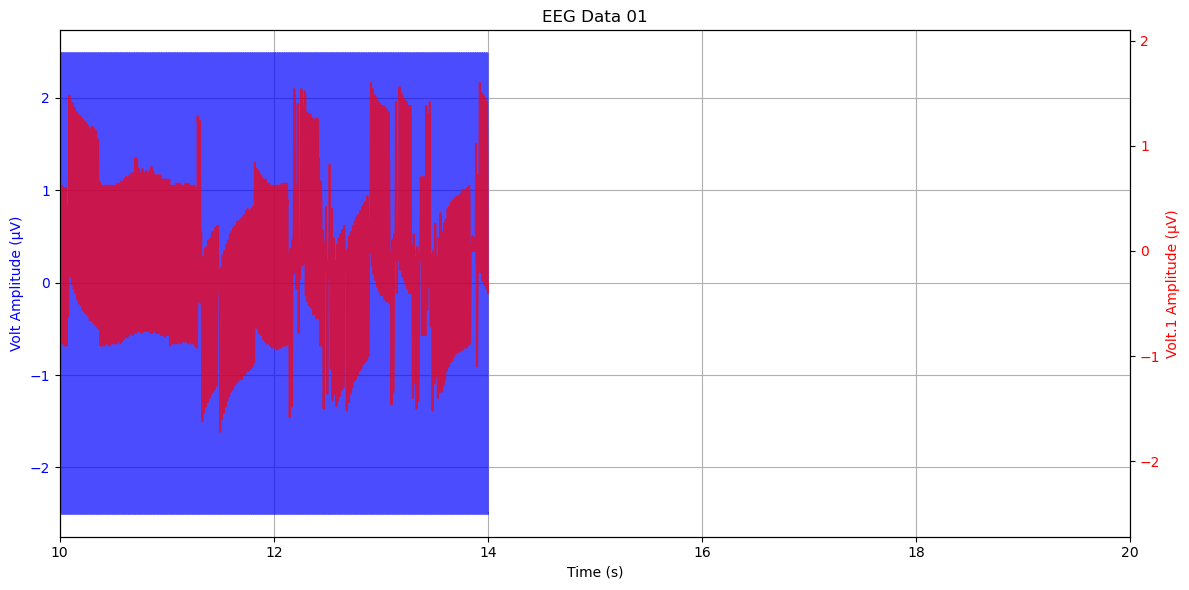

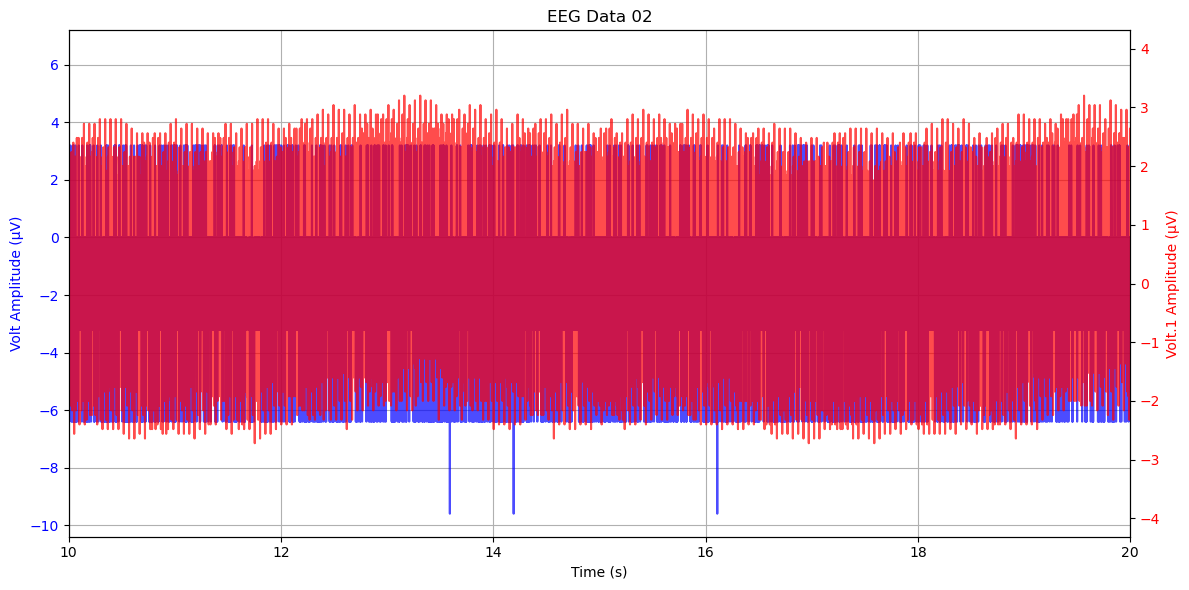

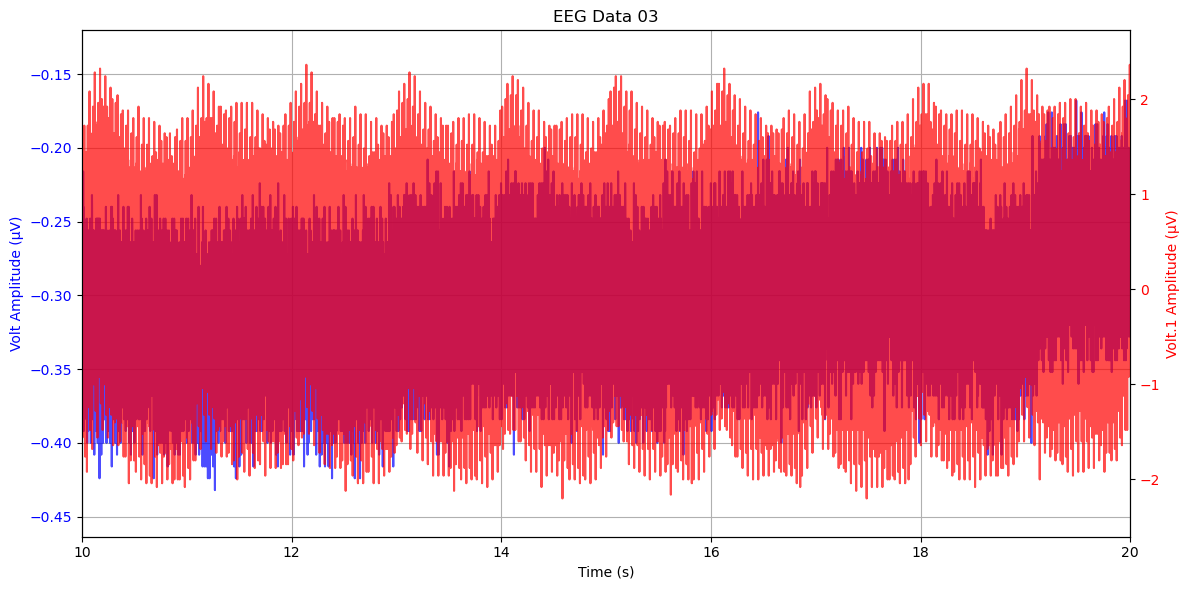

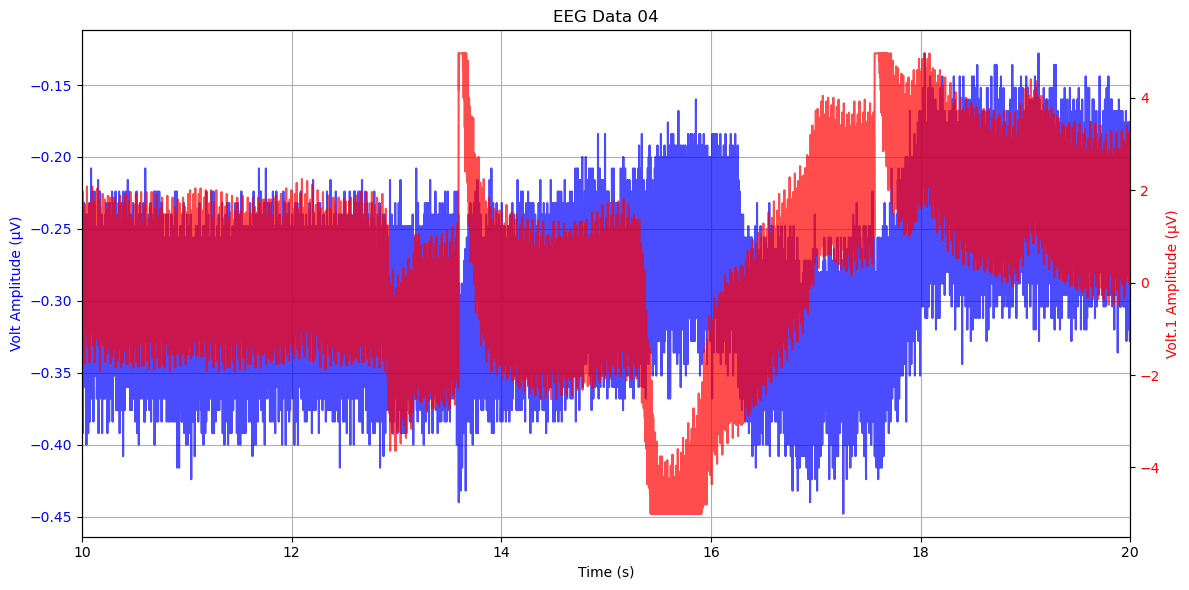

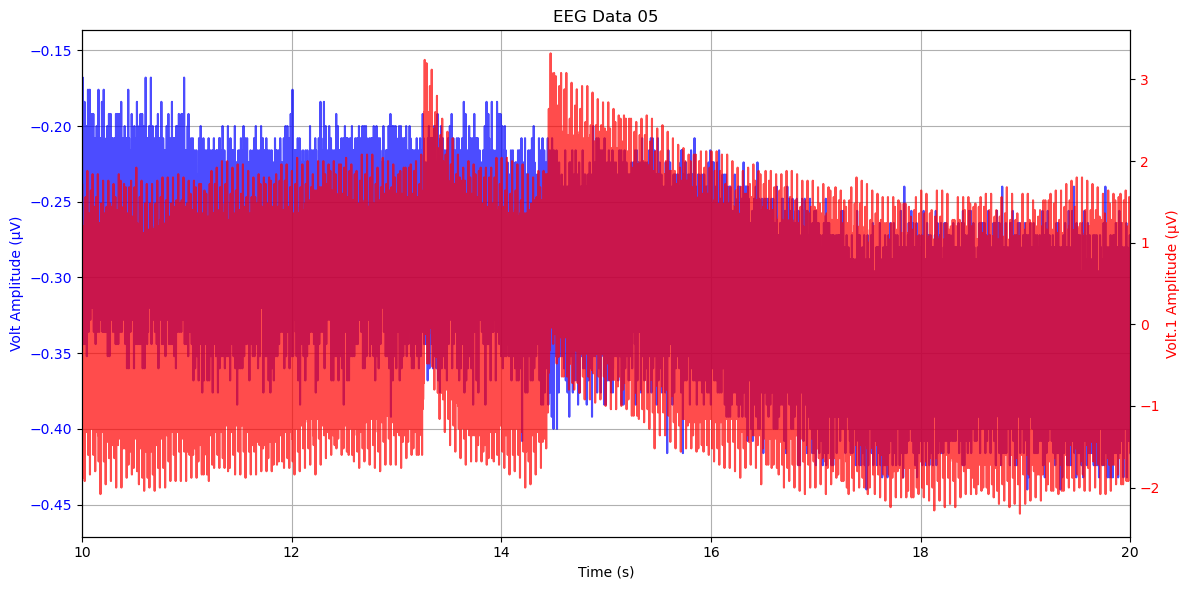

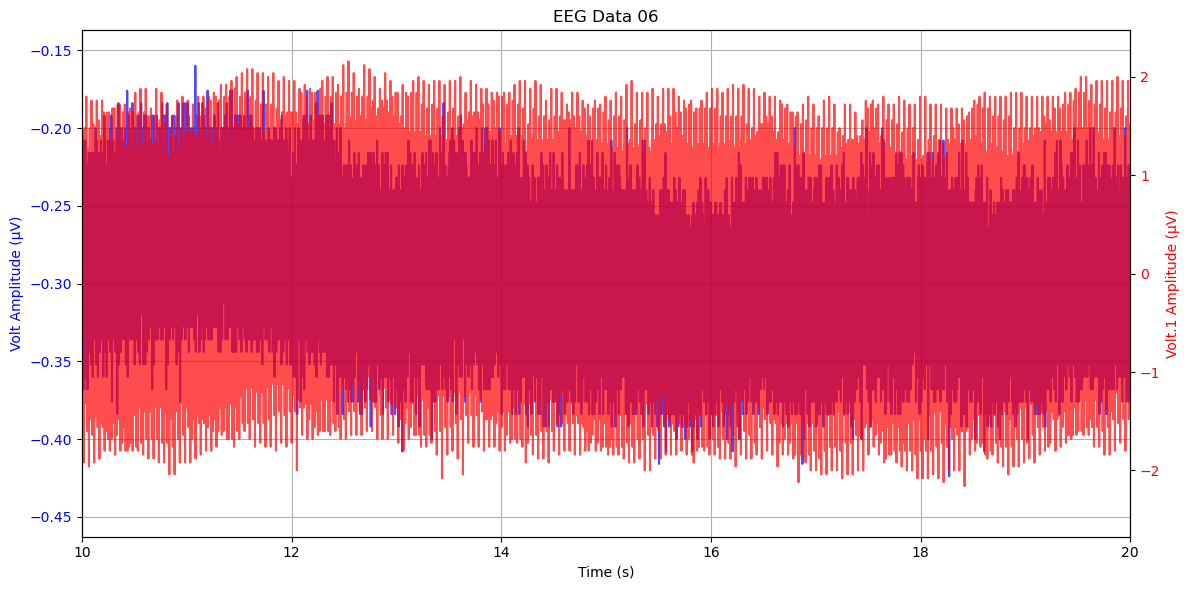

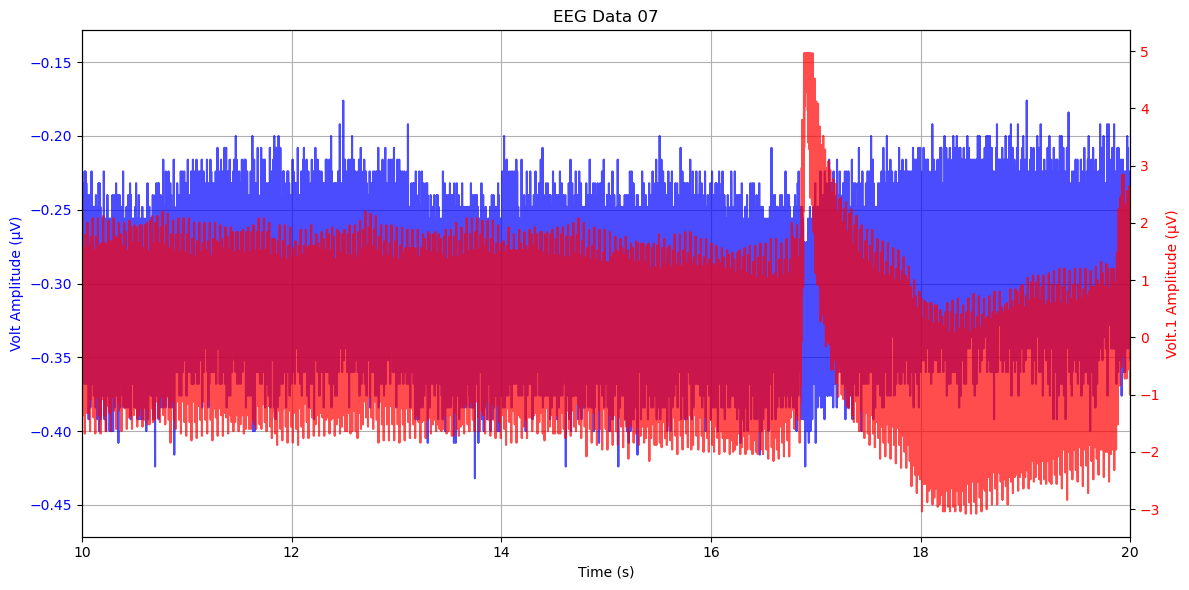

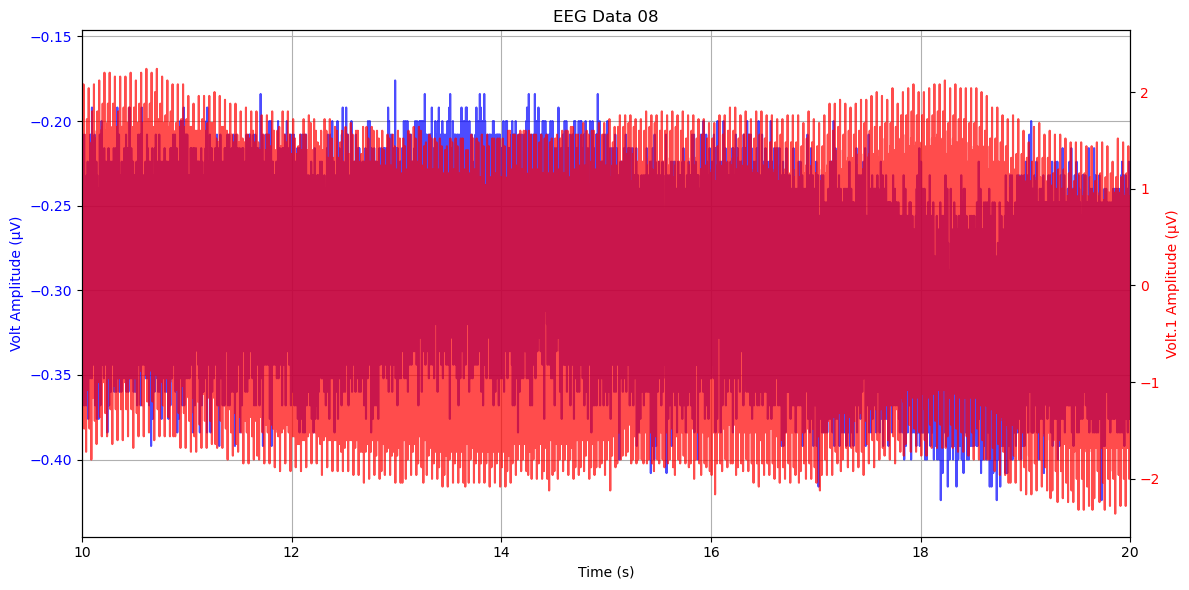

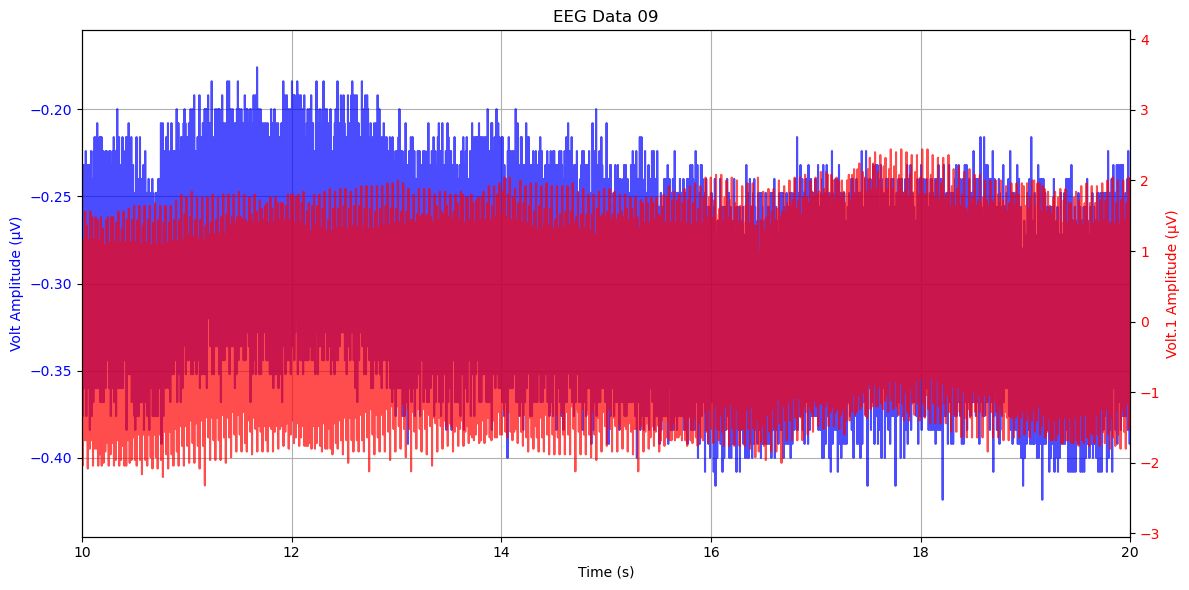

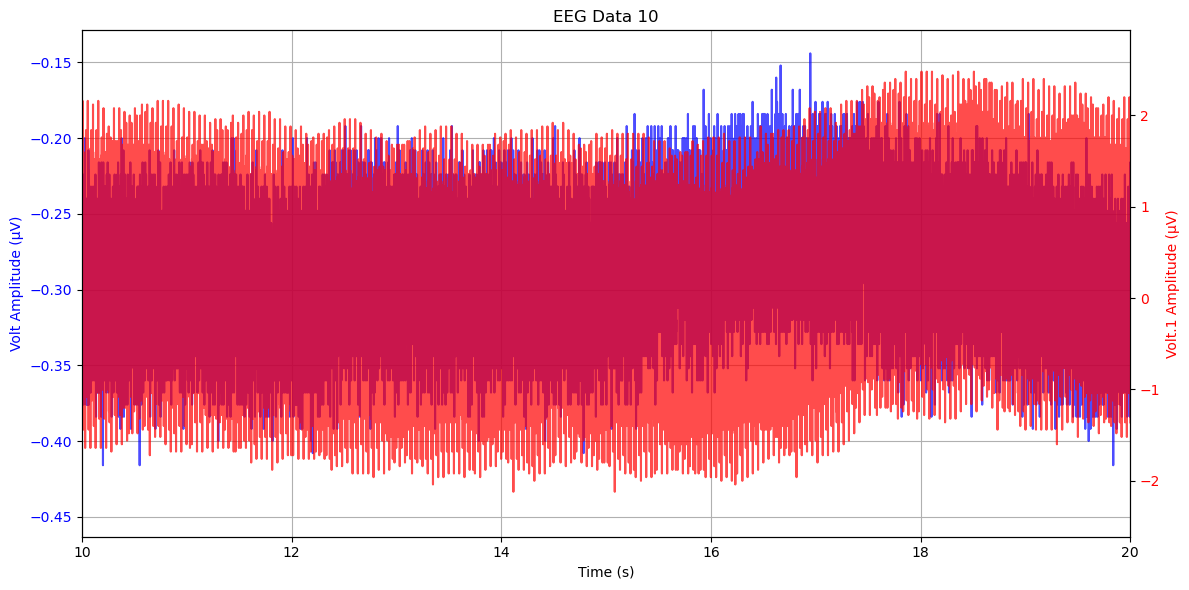

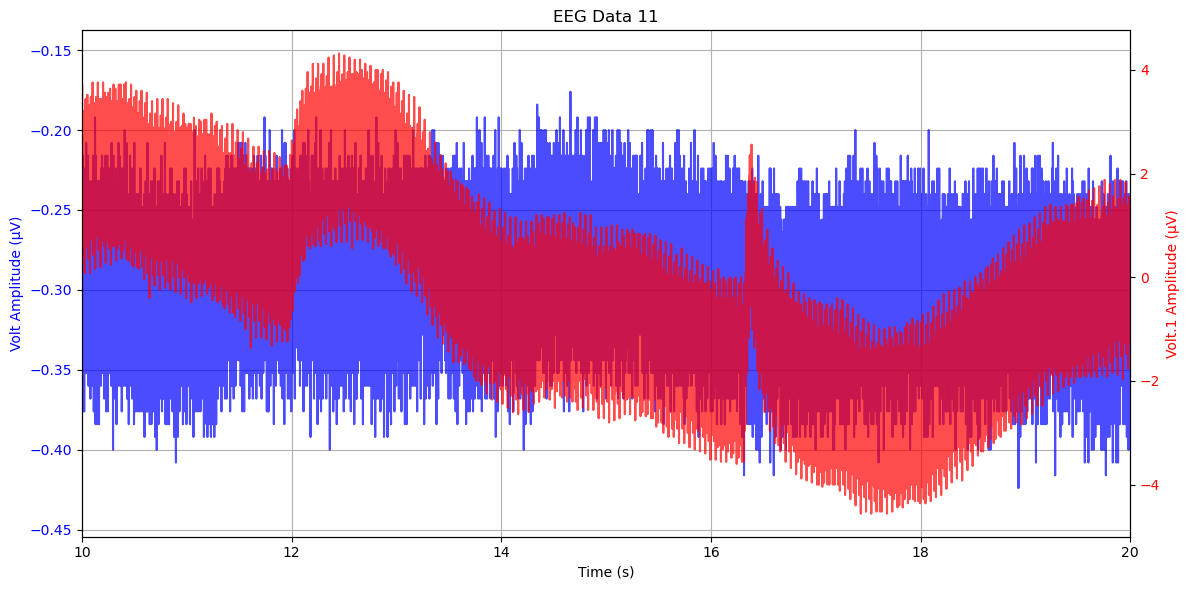

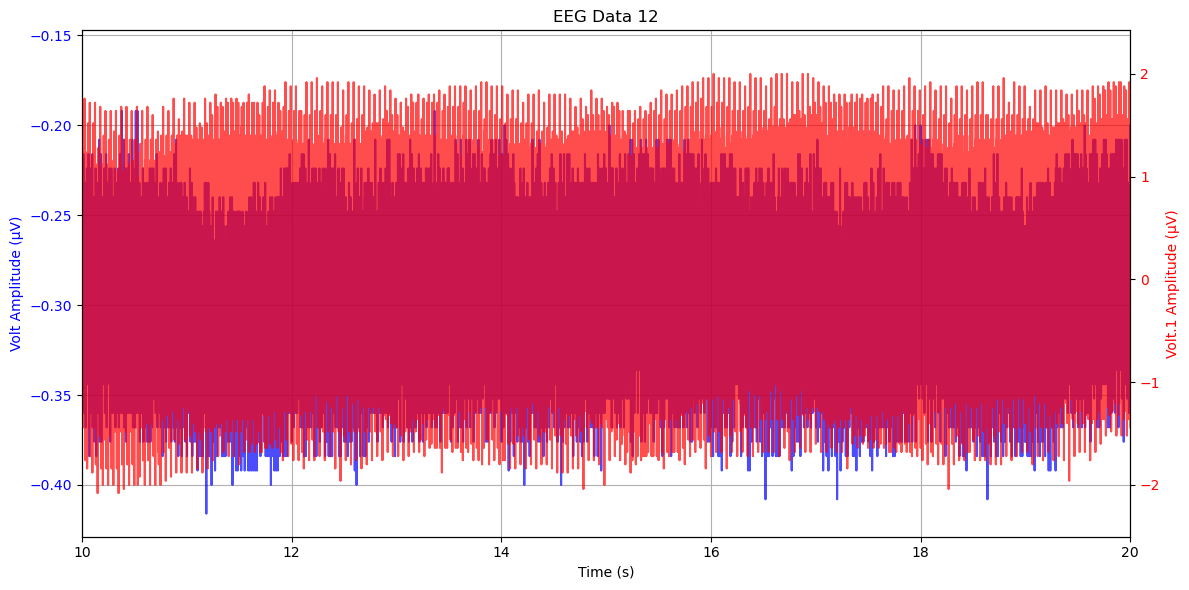

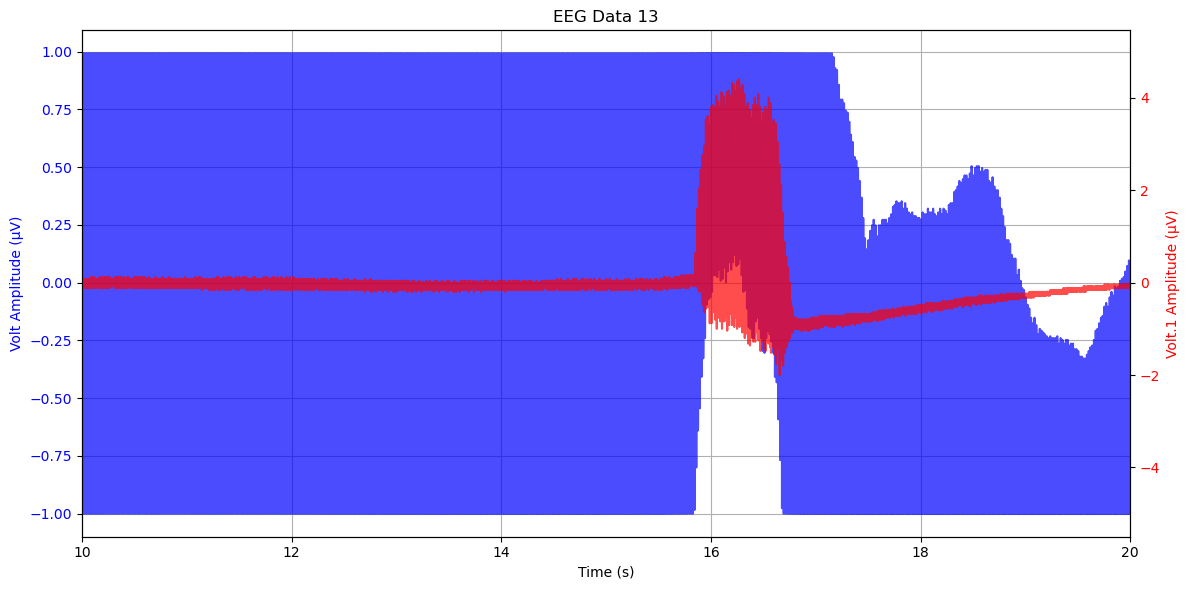

In [47]:
import matplotlib.pyplot as plt

for index, df in all_eeg_df:
    # Set 'Time' column as the x-axis
    time = df['Second']

    # Create a figure and axis
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot the first channel on the left y-axis
    channel_1 = df.columns[1]
    ax1.plot(time, df[channel_1], label=channel_1, color='b', alpha=0.7)
    ax1.set_ylabel(f'{channel_1} Amplitude (µV)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_xlabel('Time (s)')
    ax1.grid(True)

    # Create a second y-axis for the second channel
    ax2 = ax1.twinx()
    channel_2 = df.columns[2]
    ax2.plot(time, df[channel_2], label=channel_2, color='r', alpha=0.7)
    ax2.set_ylabel(f'{channel_2} Amplitude (µV)', color='r')
    ax2.tick_params(axis='y', labelcolor='r')

    # Add a title and legend
    plt.title(f'EEG Data {index}')
    
    plt.xlim(10, 20)
    
    fig.tight_layout()  # Adjust layout to prevent overlap



    plt.show()

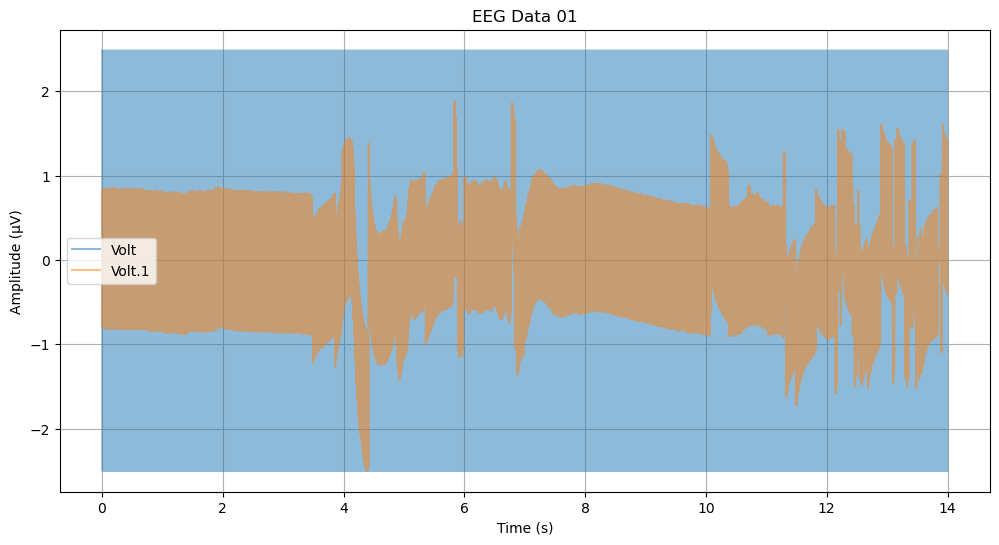

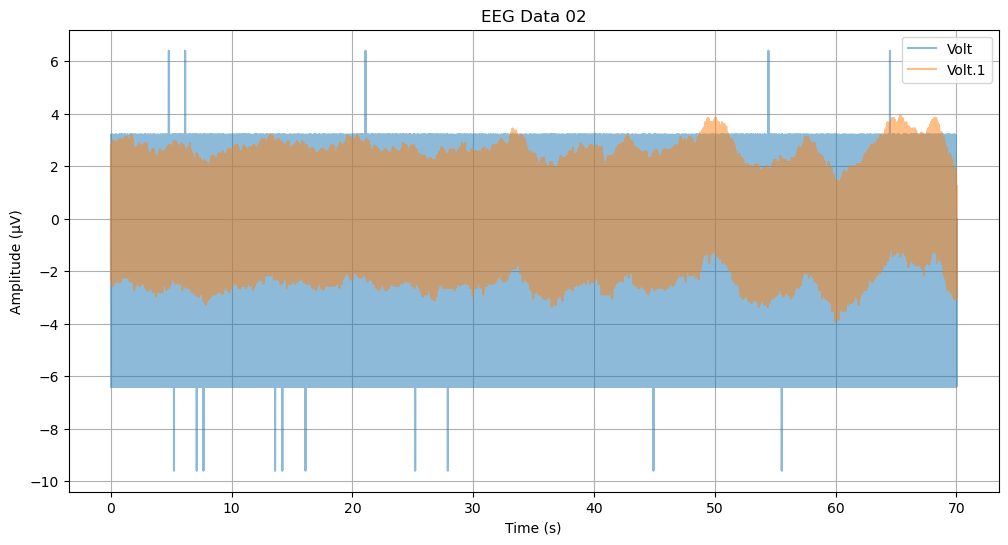

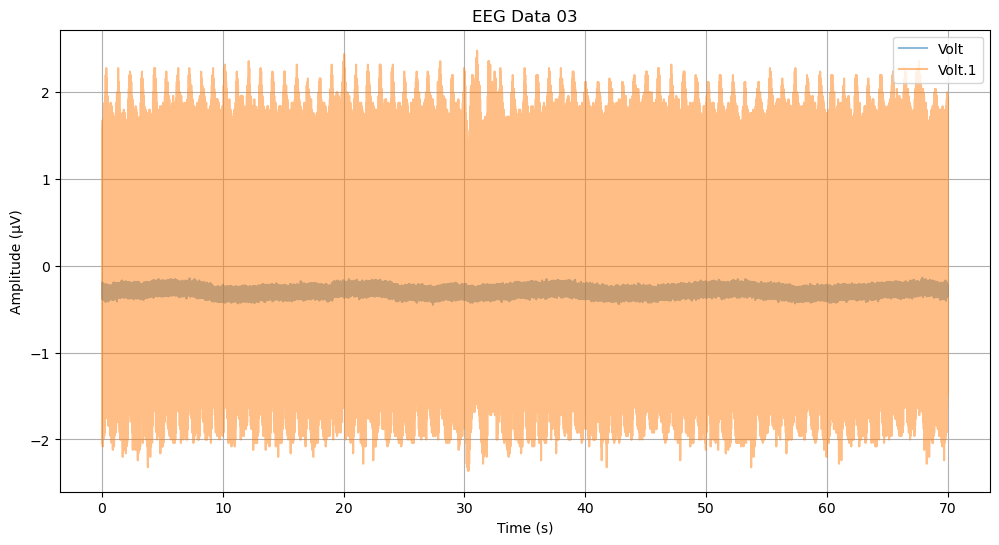

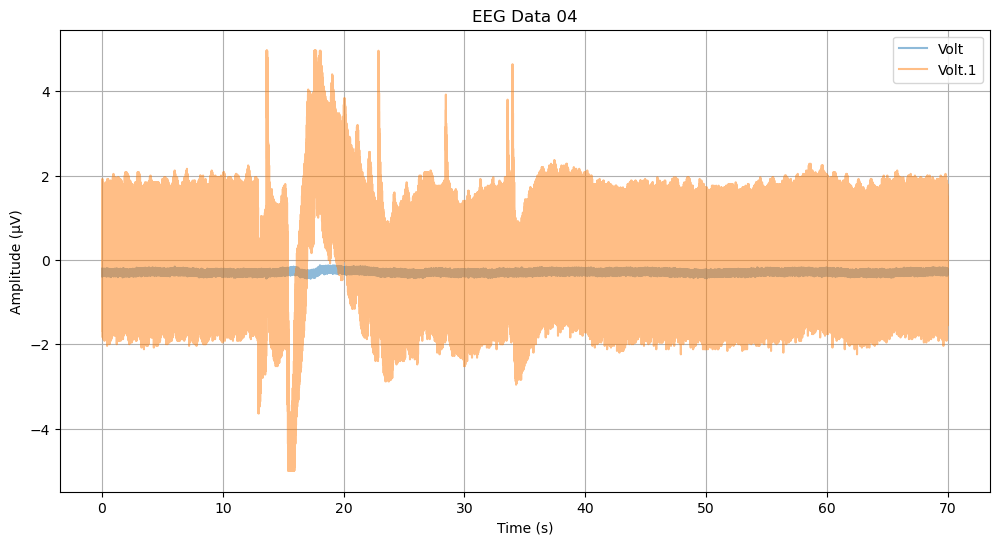

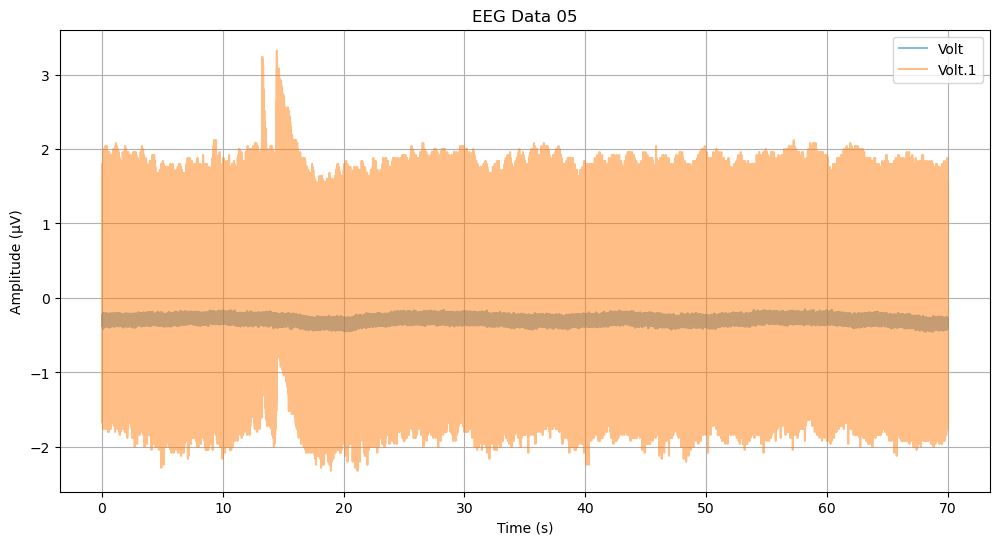

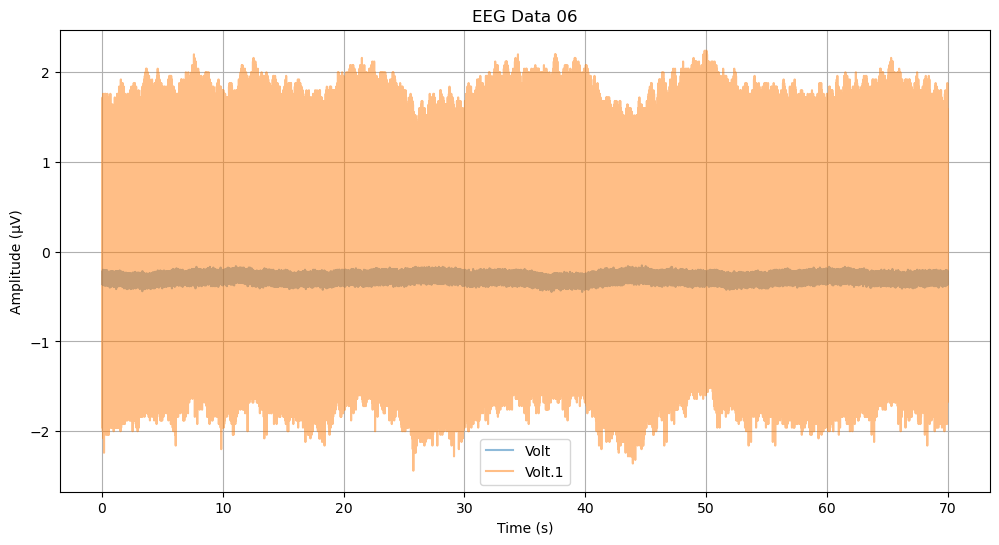

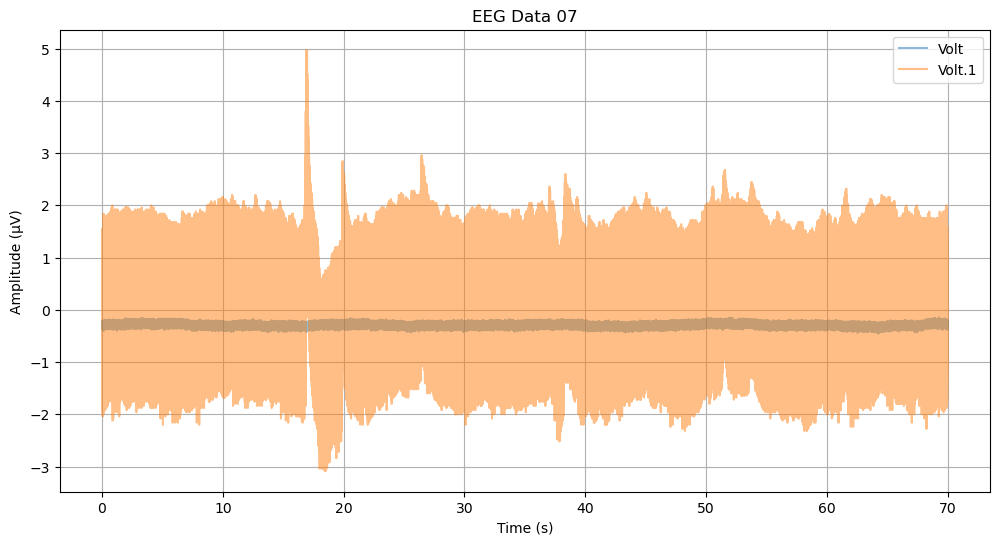

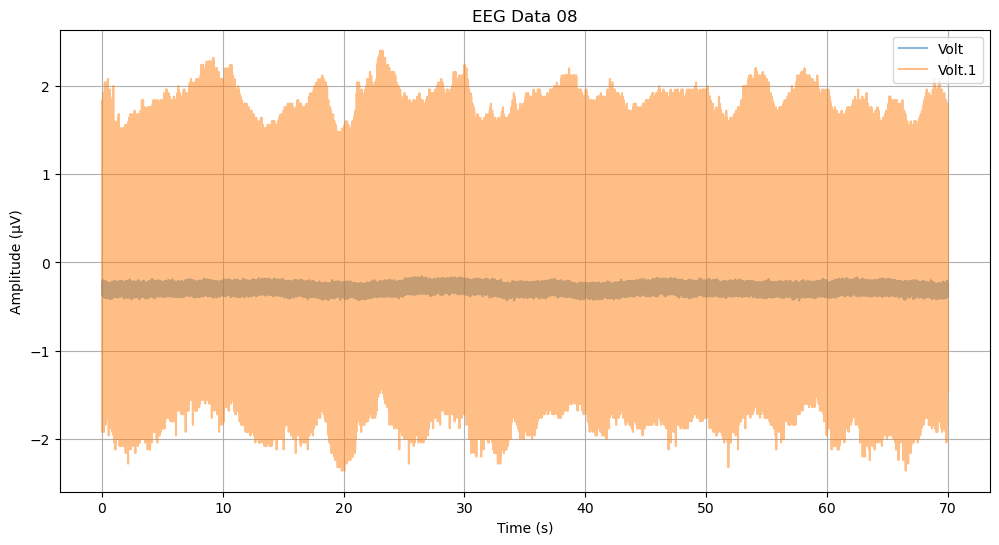

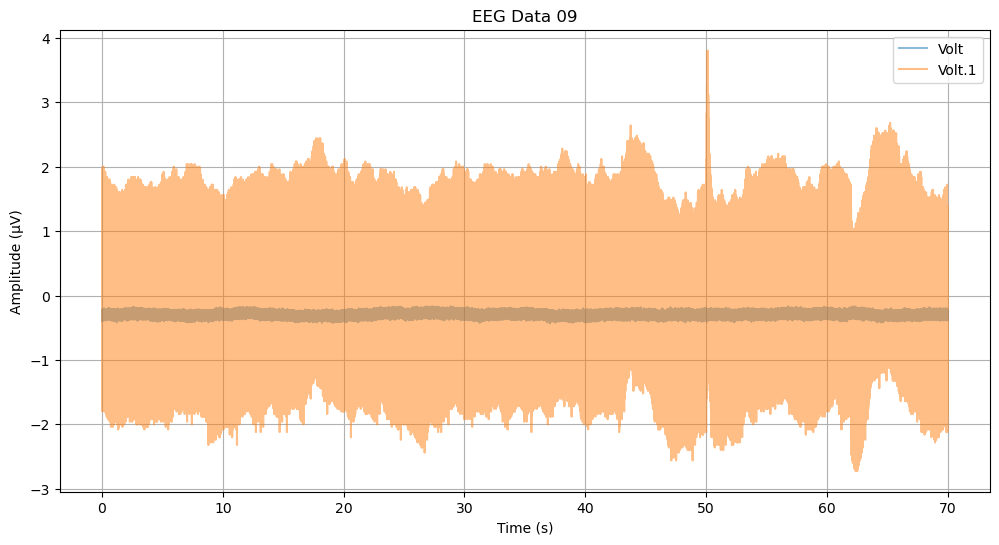

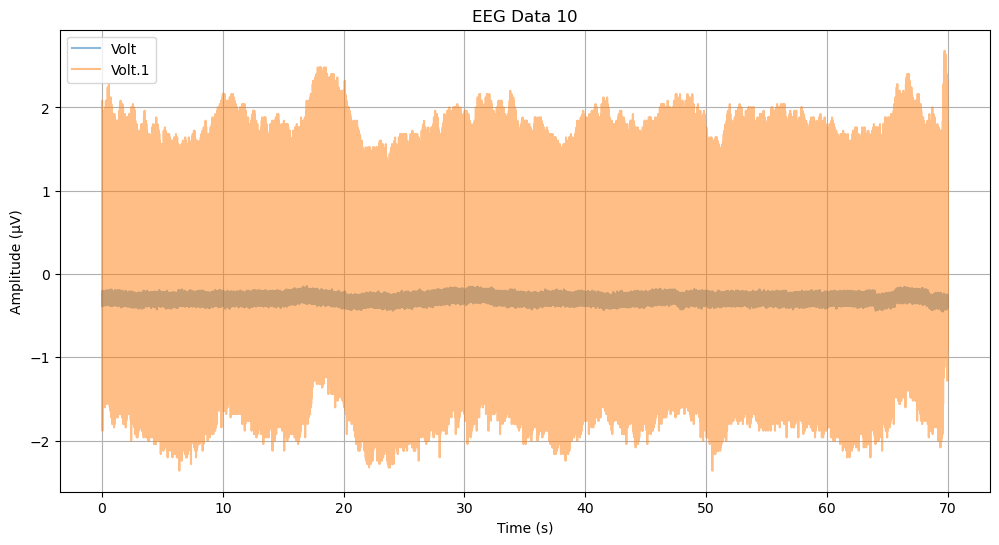

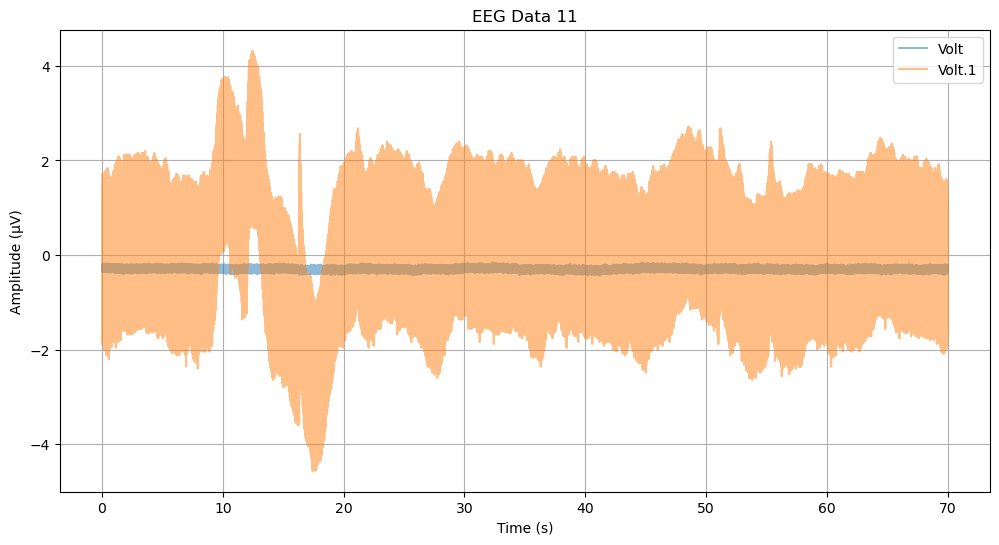

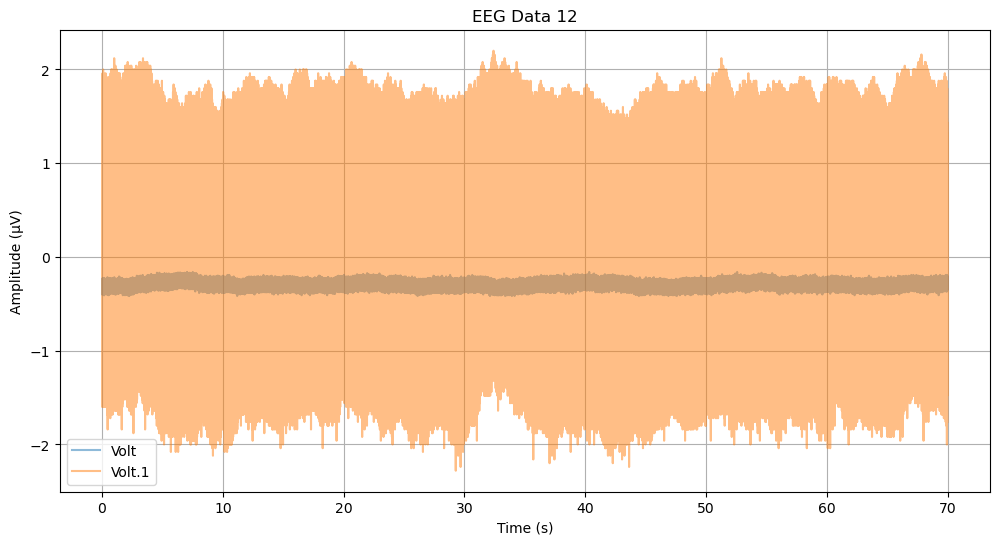

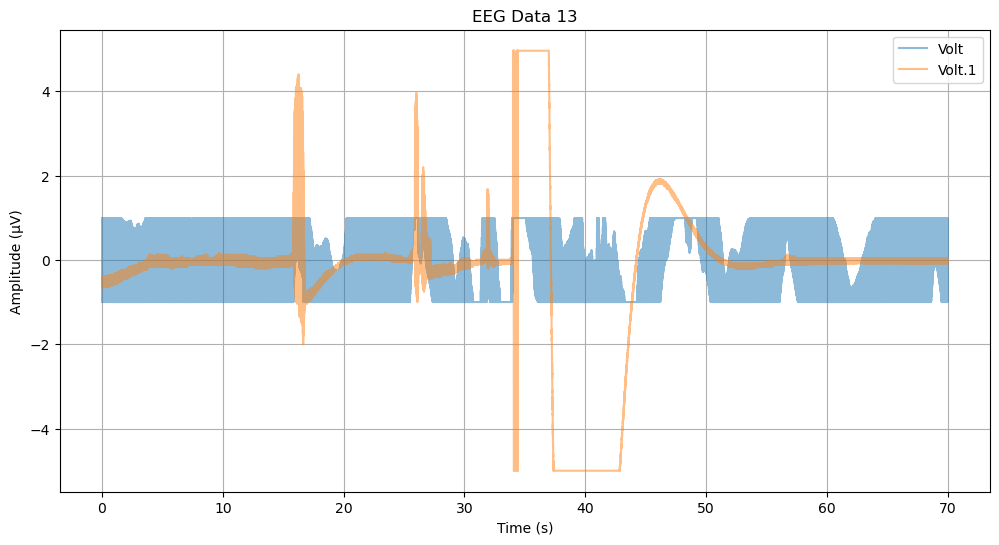

In [45]:
for index, df in all_eeg_df:
    # Set 'Time' column as the x-axis
    time = df['Second']

    # Plot each EEG channel
    plt.figure(figsize=(12, 6))
    for column in df.columns[1:]:  # Skip 'Time' column
        plt.plot(time, df[column], label=column, alpha=0.5)

    # Customize the plot
    plt.title('EEG Data {}'.format(index))
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude (µV)')
    plt.legend()
    plt.grid(True)

    # Show the plot
    plt.show()

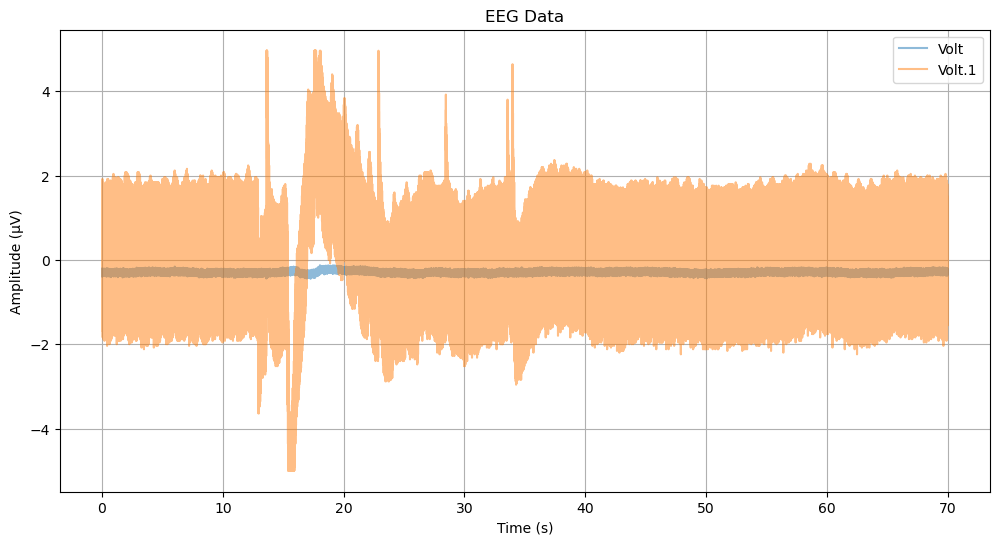

In [39]:
# Set 'Time' column as the x-axis
time = eeg_df['Second']

# Plot each EEG channel
plt.figure(figsize=(12, 6))
for column in eeg_df.columns[1:]:  # Skip 'Time' column
    plt.plot(time, eeg_df[column], label=column, alpha=0.5)

# Customize the plot
plt.title('EEG Data')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude (µV)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

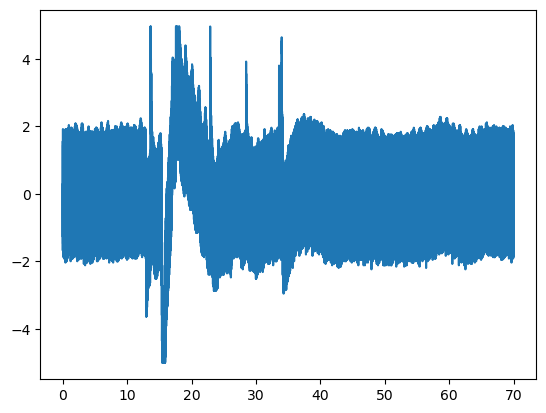

In [40]:
plt.plot(time, eeg_df[column], label=column)

In [41]:
eeg_df[column]

0        0.28
1       -0.68
2       -1.68
3        1.24
4        1.48
         ... 
69995    1.32
69996    1.20
69997   -0.64
69998   -1.16
69999   -0.76
Name: Volt.1, Length: 70000, dtype: float64